<a href="https://colab.research.google.com/github/respect5716/Deep-Learning-Paper-Implementation/blob/master/04_RL/Playing%20Atari%20with%20Deep%20Reinforcement%20Learning%20(DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing Atari with Deep Reinforcement Learning

## 0. Paper

### Info
* TItle : Playing Atari with Deep Reinforcement Learning
* Author : Volodymyr Mnih et al.
* Publication : NIPS 2013 [link](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

### Summary
* high dimensional input에 대해 end-to-end로 policy를 학습함
* experience replay를 사용하여 batch data간의 correlation을 줄임

### Differences
* Environment : Atari -> Cartpole

## 1. Settings

In [0]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Libraries
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import gym
from collections import deque

import tensorflow as tf

In [3]:
# GPU Setting
!nvidia-smi

print(f'tensorflow version : {tf.__version__}')
print(f'available GPU list : {tf.config.list_physical_devices("GPU")}')

Thu May 28 10:05:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'learning_rate' : 0.001,
    'gamma' : 0.95,
    'epsilon_max' : 1.,
    'epsilon_min' : 0.1,
    'epsilon_decay' : 0.95,
    'replay_len' : 1000,
    'batch_size' : 32,
    'episode_size' : 1000
}

## 2. Environment

In [0]:
env = gym.make('CartPole-v1')

In [0]:
state = env.reset()

In [175]:
state.shape

(4,)

## 3. Model

In [0]:
class Agent(object):
    def __init__(self, state_space, action_space):
        self.state_space = state_space
        self.action_space = action_space
        self.network, self.optimizer = self.build_network()
    
    def build_network(self):
        inputs = tf.keras.layers.Input(self.state_space)
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_space, activation='linear')(x)

        network = tf.keras.Model(inputs, outputs)
        optimizer = tf.keras.optimizers.Adam(CONFIG['learning_rate'])
        print(network.summary())
        return network, optimizer
    
    def act_by_value(self, state):
        outputs = self.network.predict(state[None,:])
        action = np.argmax(outputs)
        return action
    
    def act_by_random(self):
        action = np.random.randint(self.action_space)
        return action
    
    def train(self, batch):
        state, action, reward, next_state, done = zip(*batch)
        state = np.stack(state, axis=0)
        next_state = np.stack(next_state, axis=0)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)

        with tf.GradientTape() as tape:
            q_value = self.network(state)
            next_q_value = self.network(next_state)
            selected_q_value = tf.reduce_sum(q_value * tf.one_hot(action, self.action_space), axis=-1)
            target_q_value = reward + (1 - done) * np.max(next_q_value, axis=-1)
            loss = tf.reduce_mean(tf.square(target_q_value - selected_q_value))
        
        variables = self.network.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss

## 4. Train

In [179]:
agent = Agent(env.observation_space.shape, env.action_space.n)
replay = deque(maxlen=CONFIG['replay_len'])

epsilon = CONFIG['epsilon_max']
score_hist = []
start_time = time.time()

for i in range(CONFIG['episode_size']):
    score = 0
    done = False
    state = env.reset()

    while not done:
        if np.random.rand() < epsilon:
            action = agent.act_by_random()
        else:
            action = agent.act_by_value(state)
        epsilon = max(epsilon*CONFIG['epsilon_decay'], CONFIG['epsilon_min'])

        next_state, reward, done, _ = env.step(action)
        replay.append((state, action, reward, next_state, done))
        state = next_state
        score += reward

        if len(replay) >= CONFIG['batch_size']:
            batch = random.sample(replay, CONFIG['batch_size'])
            loss = network = agent.train(batch)
        else:
            pass
        

    score_hist.append(score)
    q_value_hist.append(max_q)

    if i % 10 == 0:
        now = time.time() - start_time
        print(f'EP : {str(i).zfill(4)} | Score : {str(int(score)).zfill(4)} | Time : {int(now)}s')

print(f'EP : {str(i+1).zfill(3)} | Score : {score} | Time : {now}s')

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_100 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_101 (Dense)            (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________
None
EP : 0000 | Score : 0012 | Time : 0s
EP : 0010 | Score : 0008 | Time : 4s
EP : 0020 | Score : 0027 | Time : 8s
EP : 0030 | Score : 0061 | Time : 16s
EP : 0040 | Score : 0083 | Time : 33s
EP : 0050 | Score : 0011 | Time : 49s
EP : 0060 | Score : 0229

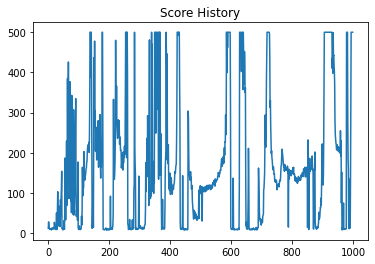

In [184]:
plt.title('Score History')
plt.plot(score_hist)
plt.show()

## 5. Test

In [186]:
for i in range(5):
    score = 0
    done = False
    state = env.reset()

    while not done:
        action = agent.act_by_value(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        score += reward

    print(f'EP : {i+1} | Score : {score}')

EP : 1 | Score : 500.0
EP : 2 | Score : 500.0
EP : 3 | Score : 500.0
EP : 4 | Score : 500.0
EP : 5 | Score : 500.0
